## Food Desert Specification
In this notebook, we will attempt to create an food desert classification on the following geographical area:

* MSOAs

In [1]:
# set up the environment
# import geospatial packages
import geopandas as gpd
import shapely

# import data manipulation modules
import pandas as pd 
import numpy as np 

# import visualisation
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
plt.style.use('ggplot')

# import osm package
import contextily as cx 
import folium
import xyzservices.providers as xyz

# import api keys
from api_keys import stadia_key, user_agent_ons
from custom_function import *
# define header
headers = {"user_agent": user_agent_ons}

/Users/Tra_FIT/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
<ipython-input-1-2e987f7fd721>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS dir

## 1. Loading the Data

We will load the following data

* `msoa` MSOA boundary geopandas dataframe in EPSG:27700
* `supermarket_ew` geopandas dataframe of point observation of supermarket within the boundary box
* `ons_census` MSOA level social demographic data, including health status, car ownership, population, and deprivation in addition to rural/urban classification

### 1.1 ONS Health (Depracated)
The ONS health data from this series is reported at the LTLA level. This dataset includes about 300 data points in England, which is significantly lower than other dataset.

In [2]:
# load the exccel file with the url
excel = pd.ExcelFile("https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/healthandsocialcare/healthandwellbeing/datasets/healthindexscoresengland/current/healthindexscoresengland.xlsx",
                     storage_options={'User-Agent': 'Mozilla/5.0'})
# define function to return the sheet
def return_health_ind_table(sheetname, col_names, geography = "LTLA"):
    df = pd.read_excel(excel, sheet_name= sheetname, skiprows = 4, usecols= [0,1,2, 34,48,49,])
    # subset for specified geography and drop area type column
    df = df.query("`Area Type [Note 3]` == @geography").drop(columns = ["Area Type [Note 3]"])
    # rename the columns 
    df.columns = col_names
    # drop the area type column
    return df

# specify the column names
col_names =["lad21cd","lad21nm","hlth_eating","obese_adult","obese_children"]
ons_health_2021 = return_health_ind_table(sheetname = "Table_3_2021_Index",col_names = col_names)
ons_health_2015 = return_health_ind_table(sheetname = "Table_9_2015_Index",col_names = col_names)


In [24]:
ons_health_2021.head()

,lad21cd,lad21nm,hlth_eating,obese_adult,obese_children
2,E06000001,Hartlepool,85.5,76.0,77.1
3,E06000002,Middlesbrough,82.2,83.0,74.5
4,E06000003,Redcar and Cleveland,75.5,87.2,77.5
5,E06000004,Stockton-on-Tees,96.0,73.7,97.6
6,E06000005,Darlington,88.4,79.7,80.2


### 1.2 MSOA Shapefile

In [2]:
# import the files
msoa = gpd.read_file("./data/MSOA_2021")
# return only england subset
msoa = msoa[msoa["MSOA21CD"].str.contains("E")]
# msoa.shape
# check crs
msoa.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

### 1.3 Food Stores

In [4]:
# # load the geojson for the supermarket locations
# preprocessed supermarket
supermarket_ew = gpd.read_file("./data/amenities_supermarket_processed.geojson")

# remove duplicates due to grid search
supermarket_ew = supermarket_ew.drop_duplicates()

# check the crs consistency
# print(f"The CRS across the geospatial data is consistent: {food_store.crs == msoa.crs}, using {food_store.crs} and {msoa.crs}")
supermarket_ew.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# transform the crs
supermarket_ew = supermarket_ew.to_crs(epsg = 27700)
# return summary stats by the shop
supermarket_ew["shop"].value_counts(normalize = True)

shop
convenience    0.722819
supermarket    0.249247
health_food    0.024726
grocery        0.003207
Name: proportion, dtype: float64

### 1.4 ONS Census Data and Urban Classification

In [9]:
# load data
ons_df = pd.read_csv("./data/ons_census_2021.csv")
# return only the urban classification
ons_df["urb"] = ons_df["RUC11"].str.contains("Urban").map({True:"Urban", False:"Rural"})
ons_df["urban"] = ons_df["RUC11"].str.contains("Urban")
urbs = ons_df[["MSOA21CD","urban","urb"]]


In [ ]:
# extract th urban row and 
msoa = msoa.merge(urbs, on = "MSOA21CD", how = "left")

## 2. Food Desert Specification
We will test for different specification for food desert:
* Number of supermarket per geographical area
* Number of supermarket per unit area aggregated at a given geographical area level (e.g. MSOA)
* Percentage of area within a defined geographical area level enclosed within 1km radius buffer from any supermarket

Note that in this section, we will only consider food stores classified as "supermarket".


In [15]:
# subset only the supermarkets
supermarket_ew = supermarket_ew[supermarket_ew["shop"] == "supermarket"]

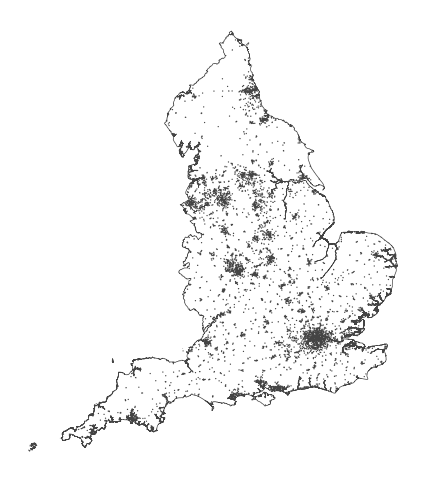

9.64% of English territories are within 1 km radius of a supermarket.


In [16]:
# # create buffer map
buffer_spmkt_1 = supermarket_ew.buffer(1000).unary_union
buffer_spmkt_5 = supermarket_ew.buffer(5000).unary_union
buffer_spmkt_10 = supermarket_ew.buffer(10000).unary_union
# # return england border
e_border = msoa.unary_union

# return intersect
catchment = buffer_spmkt_1.intersection(e_border)

# instantiate plot
fig, ax = plt.subplots(figsize = (6,6))
gpd.GeoSeries(e_border).boundary.plot(ax = ax, color = "#444444", linewidth = 0.5)
gpd.GeoSeries(catchment).plot(ax = ax, color = "#444444")
# create legend
ax.set_axis_off()
plt.savefig("./img/supermarket_catchment.png",dpi = 300)

plt.show()
# return a statistics
print(f"{catchment.area / e_border.area:.2%} of English territories are within 1 km radius of a supermarket.")

### 2.1 Specification 1 - Number of Supermarket


In [17]:
# get a subset of areas to consider
# currently set as the entire dataset
area = msoa.sample(frac = 1, random_state = 2022, replace = False)

# return the number of supermarket in the field
# instantiate an empty column
area["n_supermarket"] = 0
for id, data in area.iterrows():
    # get the number of supermarket in the area
    supermarket_in_area = supermarket_ew[supermarket_ew.geometry.within(data.geometry)]
    area.loc[id,"n_supermarket"] = len(supermarket_in_area)

In [18]:
# create bins for visualisation
area['n_supermarket_bin'] = pd.cut(area['n_supermarket'], bins = [ 0,1,5,10, 13],labels= ["1","2-5","6-10", "10+"], right= True)

In [19]:
# return the value count table
count_pivot = area["n_supermarket"].value_counts()
# create the total value
total_count = sum(count_pivot.index  * count_pivot.values)
# compute percentage of msoa without supermarket
ratio = count_pivot[0] / sum(count_pivot)
# printe the table
print(f"There are {total_count} supermarkets within England \n{count_pivot}\nBy this specification, {ratio:.2%} MSOAs cannot be effectively measured.")

There are 8399 supermarkets within England 
n_supermarket
0     2569
1     2125
2     1112
3      579
4      259
5      107
6       48
7       28
8       18
10       4
12       3
9        3
11       1
Name: count, dtype: int64
By this specification, 37.47% MSOAs cannot be effectively measured.


In [20]:
# clean the brand name and get the value counts
supermarket_ew["brand"] = supermarket_ew["brand"].str.lower()

for brand in ["tesco","sainsbury", "co-op"]:
    ind = supermarket_ew["brand"].str.contains(brand).fillna(False)
    supermarket_ew.loc[ind,"brand"] = brand

In [21]:
area.columns

Index(['MSOA21CD', 'MSOA21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID',
       'geometry', 'urban', 'urb', 'n_supermarket', 'n_supermarket_bin'],
      dtype='object')

<ipython-input-22-a837037e1c27>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(count_pivot.sort_index().index, rotation=0)


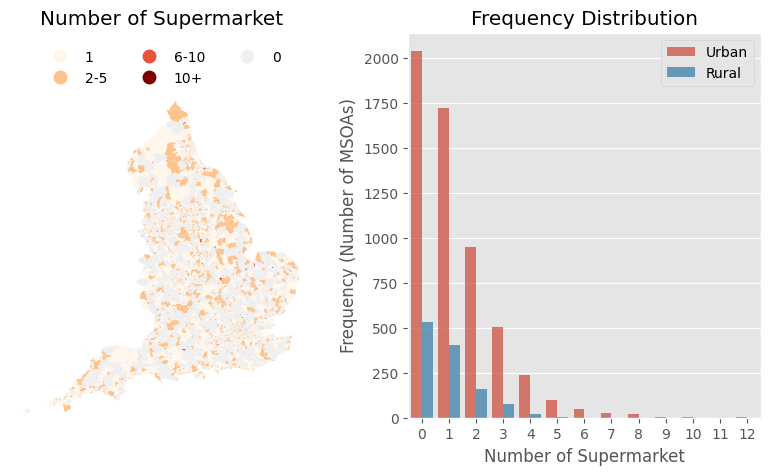

In [22]:
# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)

# create map plot
area.plot(column = "n_supermarket_bin",cmap = 'OrRd', legend = True,
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend_kwds = {'loc':(0.1,0.85), 'ncol':3,"facecolor":"#FFFFFF", "frameon":False},
          ax = ax[0])
ax[0].set_ylim(0,800000)
ax[0].set_title("Number of Supermarket")
ax[0].axis("off")

# frequency bar
ax[1].set_title("Frequency Distribution")
sns.countplot(data = area, x = "n_supermarket", hue = "urb", ax = ax[1], alpha = 0.8)
legend = ax[1].legend()
legend.texts[0].set_text("Urban")
ax[1].set_xlabel("Number of Supermarket")
ax[1].set_ylabel("Frequency (Number of MSOAs)")
ax[1].set_xticklabels(count_pivot.sort_index().index, rotation=0)
# exporting
plt.savefig("./img/n_spmkt.png", dpi = 300, bbox_inches = "tight")
plt.show()

### 2.2 Specification 2: Number of Supermarket within 1 km of the MSOA
Since there are over 30% of the MSOAs that do not have a supermarket located within their boundary, we need to consider another method to help fill in the 0 values in the column such that further manipulation can be executed.

In [23]:
# create a 1 km buffer for each msoa (if haven't contracted already)
# area_buffer = msoa.geometry.buffer(1000)

# reload the data
area_buffer = gpd.read_file("./data/msoa_1km_buffer.geojson")

In [24]:
# instantiate the column
area["n_supermarket_buffer"] = 0
for id, data in area_buffer.iterrows():
    # get the number of supermarket in the area
    supermarket_in_area = supermarket_ew[supermarket_ew.geometry.within(data.geometry)]
    id = area[area["MSOA21CD"] == data["MSOA21CD"]].index[0]
    area.loc[id,"n_supermarket_buffer"] = len(supermarket_in_area)

In [25]:
count_pivot = area["n_supermarket_buffer"].value_counts().sort_index()
# create the total value
total_count = sum(count_pivot.index  * count_pivot.values)
# compute percentage of msoa without supermarket
ratio = count_pivot[0] / sum(count_pivot)
# printe the table
print(f"By this specification, {ratio:.2%} MSOAs cannot be effectively measured.")


By this specification, 2.86% MSOAs cannot be effectively measured.


In [26]:
# return high level index
threshold = 13
inds =  count_pivot.index[count_pivot.index >= threshold]
# add a sum row
count_pivot[f"{threshold}+"] = count_pivot[inds].sum()
# drop the inds beyond the some
count_pivot = count_pivot.drop(index = inds)

In [27]:
area['n_supermarket_buffer_bin'] = pd.cut(area['n_supermarket_buffer'], bins = [ 0,1,5,10, 50],labels= ["1","2-5","6-10", "10+"], right= True)

In [28]:
count_pivot

n_supermarket_buffer
0      196
1      445
2      730
3      895
4      830
5      750
6      662
7      537
8      419
9      306
10     177
11     177
12     131
13+    601
Name: count, dtype: int64

<ipython-input-29-551e7caf9c99>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)


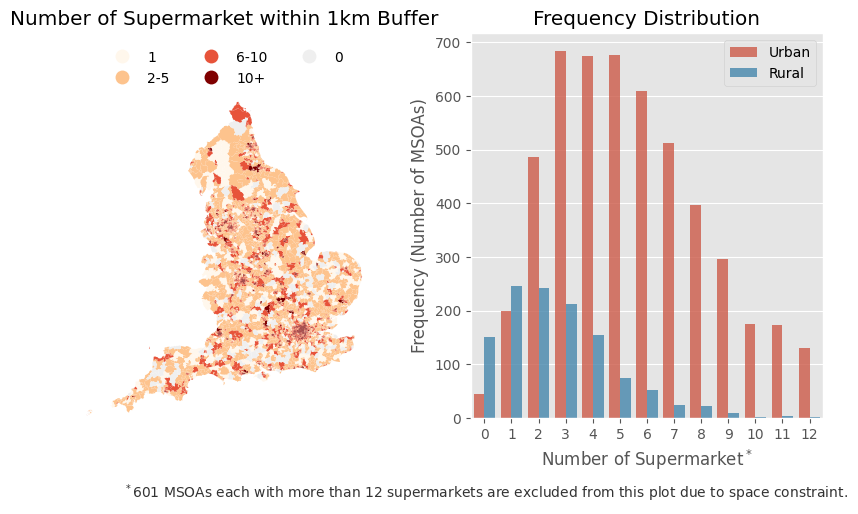

In [29]:
# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)

# create map plot
area.plot(column = "n_supermarket_buffer_bin",cmap = 'OrRd', legend = True,
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend_kwds = {'loc':(0.1,0.85), 'ncol':3,"facecolor":"#FFFFFF", "frameon":False},
          ax = ax[0])
ax[0].set_ylim(0,800000)
ax[0].set_title("Number of Supermarket within 1km Buffer")
ax[0].axis("off")


# frequency bar
ax[1].set_title("Frequency Distribution")
# count_pivot.plot(kind = "bar", ax = ax[1])
sns.countplot(data = area.sort_values("urb",ascending = False), x = "n_supermarket_buffer", hue = "urb", ax = ax[1], alpha = 0.8)
legend = ax[1].legend()
legend.texts[0].set_text("Urban")
legend.texts[1].set_text("Rural")
ax[1].set_xlabel("Number of Supermarket$^*$")
ax[1].set_ylabel("Frequency (Number of MSOAs)")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
ax[1].set_xlim(-0.5,12.5)
# add annotation
annotation = "$^*$601 MSOAs each with more than 12 supermarkets are excluded from this plot due to space constraint."
fig.text(0.2,-0.05,annotation,fontsize = 10, color  = "#333333", fontweight = "light")

# exporting
plt.savefig("./img/no_smkt_buffer.png", dpi = 300, bbox_inches = "tight")
plt.show()

### 2.3 Specification 3: Number of Supermarket Per Unit Area

In [30]:
# return the area of the geometry
area["area"] = area.geometry.area 
# return supermarket per unit area
area["d_supermarket"] = area["n_supermarket_buffer"] / (area["area"]/ 10**6)
# return nnumber of supermarket adj for urban rural class

In [31]:
area["d_supermarket"].describe()

count    6856.000000
mean        3.608956
std         6.323857
min         0.000000
25%         0.302229
50%         1.487510
75%         3.864478
max        76.980416
Name: d_supermarket, dtype: float64

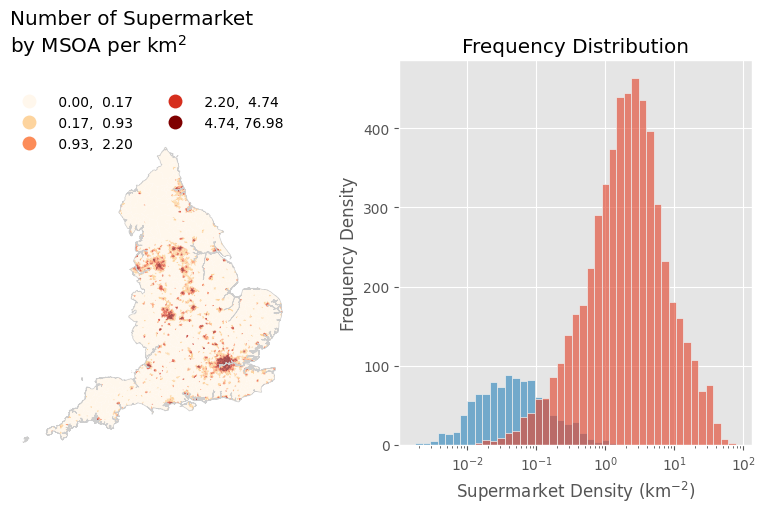

In [32]:
# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
area.plot(column = "d_supermarket", cmap='OrRd',scheme='quantiles',
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend = True,
          legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title("Number of Supermarket \nby MSOA per km$^2$", loc = "left")
ax[0].set_axis_off()


ax[1].set_title("Frequency Distribution")
sns.histplot(data = area.sort_values("urb",ascending = False), x = "d_supermarket", hue = "urb", ax = ax[1], alpha = 0.65, log_scale= True, legend = False)
# legend = ax[1].legend()
# legend.texts[0].set_text("Urban")
# legend.texts[1].set_text("Rural")
# area['d_supermarket'].hist(bins = 12, ax = ax[1])
ax[1].set_xlabel("Supermarket Density (km$^{-2}$)")
ax[1].set_ylabel("Frequency Density")

plt.savefig("./img/n_smrt_area.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [33]:
area.sort_values("d_supermarket", ascending = False)[["MSOA21CD","MSOA21NM","d_supermarket"]].head(10)

,MSOA21CD,MSOA21NM,d_supermarket
6849,E02007110,Hackney 032,76.980416
820,E02000869,Tower Hamlets 006,68.469898
823,E02000872,Tower Hamlets 009,61.213155
353,E02000378,Hammersmith and Fulham 007,57.741767
346,E02000370,Hackney 026,57.329030
355,E02000380,Hammersmith and Fulham 009,53.908113
351,E02000376,Hammersmith and Fulham 005,53.670207
1820,E02001908,Birmingham 082,52.799658
685,E02000722,Newham 009,50.868256
539,E02000571,Islington 018,48.062156


### 2.4 Specification 4: Percentage Area within the Catchment Area
We need to compute between Rural and Urban

In [34]:
# return the unary of supermarket buffer (already executed)
# buffer_spmkt_1
# buffer_spmkt_10
# buffer_spmkt_5
# gpd.GeoSeries(buffer_spmkt_5).plot()
# plt.show()

In [35]:
# iterate through the msoa and return the area within catchment
for id, data in area.iterrows():
    # return the catchment size by the area urban classification
    if data["urban"]:
        geom = buffer_spmkt_1
    else:
        geom = buffer_spmkt_5
    # return intersection
    intersection = data.geometry.intersection(geom)
    area.loc[id,"in_catchment"] = intersection.area
# normalize as percentage
area["in_catchment"] = area["in_catchment"] / area["area"]

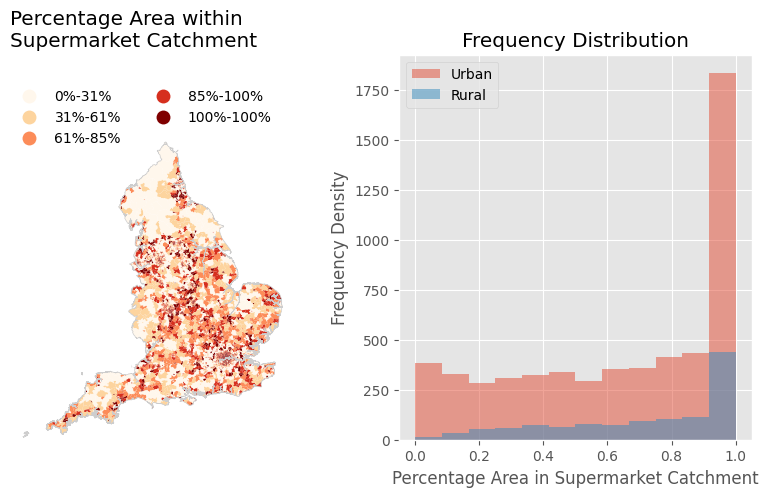

In [14]:
# instantiate plot
fig, ax = plt.subplots(figsize = (10,5),ncols = 2)
# plot the choropleth
area.plot(column = "in_catchment", cmap='OrRd',scheme='quantiles',
          missing_kwds = {'color' : "#EFEFEF", 'label': 0},
          legend = True,
          legend_kwds = {'loc':(0,0.75), 'ncol':2,"facecolor":"#FFFFFF", "frameon":False},
          ax=ax[0])
# plot the boundary
gpd.GeoSeries(e_border).boundary.plot(ax=ax[0], color = "#CDCDCD", linewidth = 0.5)

ax[0].set_ylim(0,850000)
ax[0].set_title("Percentage Area within\nSupermarket Catchment", loc = "left")
ax[0].set_axis_off()
# format the legend label
leg = ax[0].get_legend()
for text in leg.get_texts():
    # get the upper and lower bound
    limits = [float(lim) for lim in  text.get_text().split(",")]
    # paraw as lavle
    label = f"{limits[0]:.0%}-{limits[1]:.0%}"
    text.set_text(label)


ax[1].set_title("Frequency Distribution")
# plot urban
area[area["urban"]]['in_catchment'].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Urban")
area[~area["urban"]]['in_catchment'].hist(bins = 12, ax = ax[1], alpha = 0.5, label = "Rural")
ax[1].set_xlabel("Percentage Area in Supermarket Catchment")
ax[1].set_ylabel("Frequency Density")
ax[1].legend()

plt.savefig("./img/n_smrt_catchment_pct_5.png", dpi = 300, bbox_inches = "tight")
plt.show()

## 3. Export

In [37]:
# return onl
output = area[['MSOA21CD', 'MSOA21NM','area', 'urban','n_supermarket', 'd_supermarket', 'n_supermarket_buffer','in_catchment']]
output.to_csv("./data/food_access_spec.csv", index= False)